In [5]:
import pandas as pd

df = pd.read_parquet("../data/processed/reviews_clean.parquet")
print(df.shape)
print(df.sample(3)[["business_name", "rating", "text_clean"]])


(1100, 18)
     business_name  rating                                         text_clean
707       Ege Vera       5  portions are big. the flavors are nice. servic...
1028    Say Cheese       4  a delicious masterpiece comes out when it is m...
270     Bunbun Kas       5  i can say that cleanliness; taste; warm-bloode...


01 — Exploratory Data Analysis (Google Reviews)
- Uses processed file from `src/preprocess.py`
- Focus: distributions, text stats, suspicious patterns (URLs, ALLCAPS, short texts), author/business behaviour.

In [7]:
import os, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option("display.max_colwidth", 200)

DATA_PARQUET = "../data/processed/reviews_clean.parquet"


 0) Load

In [8]:
assert os.path.exists(DATA_PARQUET), f"Not found: {DATA_PARQUET}"
df = pd.read_parquet(DATA_PARQUET)
print(df.shape)
df.head(3)

(1100, 18)


,business_name,author_name,photo_path,has_photo,rating,category_raw,category_id,text_raw,text_clean,has_url,length_chars,length_tokens,num_exclaim,num_question,num_caps_tokens,is_short,timestamp,review_id
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,dataset/taste/hacinin_yeri_gulsum_akar.png,True,5,taste,3,We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. ...,we went to marmaris with my wife for a holiday. we chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. when we first went there was a serious queue. ...,False,680,130,0,0,1,False,None,197806708066612212
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,dataset/menu/hacinin_yeri_oguzhan_cetin.png,True,4,menu,1,During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without ...,during my holiday in marmaris we ate here to fit the food. it's really good that the food is cheap and nice. eating as much bread as you want is a big plus for those who are not satisfied without ...,False,914,179,0,0,1,False,None,-5007835207484769476
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,dataset/outdoor_atmosphere/hacinin_yeri_yasin_kuyu.png,True,3,outdoor_atmosphere,2,Prices are very affordable. The menu in the photo cost 108 liras. You have to wait 10-15 minutes for food. Staff is annoying. Well it tastes good. Boiled meat was delicious.,prices are very affordable. the menu in the photo cost 108 liras. you have to wait 10-15 minutes for food. staff is annoying. well it tastes good. boiled meat was delicious.,False,173,31,0,0,0,False,None,-6239589702024109076


1) Basic structure & missing values

In [9]:
print(df.info())
print("\nMissing values:\n", df.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   photo_path       1100 non-null   object
 3   has_photo        1100 non-null   bool  
 4   rating           1100 non-null   int64 
 5   category_raw     1100 non-null   object
 6   category_id      1100 non-null   Int16 
 7   text_raw         1100 non-null   object
 8   text_clean       1100 non-null   object
 9   has_url          1100 non-null   bool  
 10  length_chars     1100 non-null   int64 
 11  length_tokens    1100 non-null   int64 
 12  num_exclaim      1100 non-null   int64 
 13  num_question     1100 non-null   int64 
 14  num_caps_tokens  1100 non-null   int64 
 15  is_short         1100 non-null   bool  
 16  timestamp        0 non-null      object
 17  review_id        1100 non-null   

2) Duplicate check + quick preview

In [10]:
dupes = df.duplicated(subset=["business_name","author_name","text_clean"]).sum()
print("Exact dupes (business, author, text_clean):", dupes)

print("\nRandom sample:")
cols = ["business_name","author_name","rating","category_raw","has_url","length_tokens","num_exclaim","num_caps_tokens","text_clean"]
display(df[cols].sample(min(5, len(df)), random_state=42))

Exact dupes (business, author, text_clean): 0

Random sample:


,business_name,author_name,rating,category_raw,has_url,length_tokens,num_exclaim,num_caps_tokens,text_clean
328,Sardalye,Guney Gecer,4,taste,False,23,0,0,i went to there with my girl friend; i liked fishes but she did not like because fishes are a little bit oily.
688,Duveroglu,Can Akkaynak,4,menu,False,13,0,0,good in general. quality for kızılay and its surroundings. lahmacun doesn't taste old...
413,Pecko Firin Atakum,Burhan Arslan,5,taste,False,16,0,0,my first stop for breakfast in atakum is a place with quality service and friendly face.
788,Asucan Restaurant,Kjiong Son,3,indoor_atmosphere,False,4,0,0,place was not clear.
244,Tuana Restaurant,Ahmet Ekim,1,taste,False,50,1,4,definitely do not come. we came here for breakfast based on the reviews on the way. we said the breakfast called the village breakfast for 2 people. first of all; the employee greeted us disrespec...


3) Distributions - ratings and review lengths

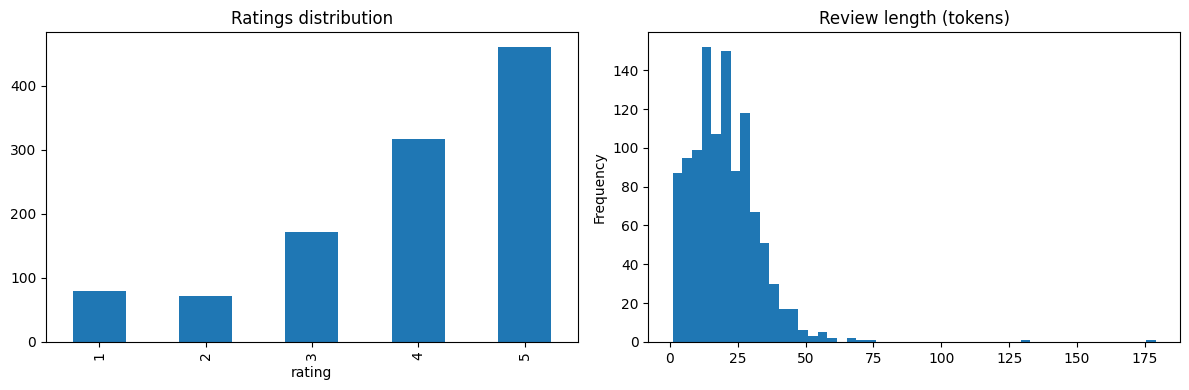

Mean tokens: 20.05
Median tokens: 19.0


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["rating"].dropna().astype(int).value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Ratings distribution")
df["length_tokens"].plot(kind="hist", bins=50, ax=axes[1], title="Review length (tokens)")
plt.tight_layout()
plt.show()

print("Mean tokens:", df["length_tokens"].mean().round(2))
print("Median tokens:", df["length_tokens"].median())

4) Text signals linked to policies

In [12]:
print("Has URL (%):", (df["has_url"].mean()*100).round(2))
print("Short reviews (<=10 tokens) (%):", (df["is_short"].mean()*100).round(2))
print("Avg exclamation marks:", df["num_exclaim"].mean().round(3))
print("Avg ALLCAPS tokens:", df["num_caps_tokens"].mean().round(3))

# how many reviews look potentially 'ad-like' or 'spammy' by rough heuristics
heur_ad = (df["has_url"]) | (df["num_caps_tokens"] >= 3)
print("Heuristic ad-like (%):", (heur_ad.mean()*100).round(2))

Has URL (%): 0.0
Short reviews (<=10 tokens) (%): 22.73
Avg exclamation marks: 0.085
Avg ALLCAPS tokens: 0.045
Heuristic ad-like (%): 0.09


- Peek examples for each signal

In [13]:
def show_examples(mask, n=5, columns=None, title=""):
    cols = columns or ["business_name","author_name","rating","text_clean"]
    subset = df.loc[mask, cols].head(n)
    print(f"\n{title}  count={mask.sum()}\n")
    display(subset)

show_examples(df["has_url"], 5, title="Examples: has_url == True")
show_examples(df["is_short"], 5, title="Examples: is_short == True")
show_examples(df["num_caps_tokens"] >= 3, 5, title="Examples: many ALLCAPS tokens (>=3)")
show_examples(df["num_exclaim"] >= 3, 5, title="Examples: many exclamations (>=3)")


Examples: has_url == True  count=0



,business_name,author_name,rating,text_clean



Examples: is_short == True  count=250



,business_name,author_name,rating,text_clean
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,5,turkey's cheapest artisan restaurant and its food is delicious!
5,Haci'nin Yeri - Yigit Lokantasi,Arda Karaca,4,generally good.
7,Haci'nin Yeri - Yigit Lokantasi,Nadia Salim,5,delicious food at rock bottom prices. friendly staff; highly recommend
9,Haci'nin Yeri - Yigit Lokantasi,Celal Ozer,5,the most f/p of all businesses i've seen.
25,Cafe Inn,Tugba Gunaydin,4,the vegan breakfast made me extremely happy. it was nice.



Examples: many ALLCAPS tokens (>=3)  count=1



,business_name,author_name,rating,text_clean
244,Tuana Restaurant,Ahmet Ekim,1,definitely do not come. we came here for breakfast based on the reviews on the way. we said the breakfast called the village breakfast for 2 people. first of all; the employee greeted us disrespec...



Examples: many exclamations (>=3)  count=2



,business_name,author_name,rating,text_clean
23,Cafe Inn,Hooman Sadati,1,without any taste how they are at the first rank!!!! we ate cafe inn pizza. it was 70 tl.
589,Sanukiya,Arthur Jonathan,5,the queue was not that long fortunately! the staffs were all very kind and welcoming. the food was amazing! the udon was the hero; it was very flavorful & juicy!


5) Business-level & author-level behaviour

In [14]:
biz_counts = df["business_name"].value_counts()
print("Businesses — top 10 by review count:")
display(biz_counts.head(10).to_frame("num_reviews"))

# proportion of URL reviews per business (suspicion)
biz_url_rate = df.groupby("business_name")["has_url"].mean().sort_values(ascending=False)
print("\nBusinesses with highest URL rate (top 10):")
display((biz_url_rate.head(10)*100).round(1).to_frame("%_has_url"))

# authors reviewing many different businesses (possible paid accounts)
auth_span = df.groupby("author_name")["business_name"].nunique().sort_values(ascending=False)
print("\nAuthors reviewing most unique businesses (top 10):")
display(auth_span.head(10).to_frame("unique_businesses"))

Businesses — top 10 by review count:


,num_reviews
business_name,
Haci'nin Yeri - Yigit Lokantasi,11
Rumeli Iskembecisi,11
Koco Restaurant,11
Ciya Sofrasi,11
Asucan Restaurant,11
Sema Gozleme,11
Umut Pide,11
Yesemek,11
Balikci Tanju,11



Businesses with highest URL rate (top 10):


,%_has_url
business_name,
Abidin Tantuni,0.0
Midpoint,0.0
Pecko Firin Atakum,0.0
Patso Burger,0.0
Nusr-et,0.0
Nesh,0.0
Nazar Cafe,0.0
My Friends Burger,0.0
Monica Kitchen,0.0



Authors reviewing most unique businesses (top 10):


,unique_businesses
author_name,
Nihat Karabiber,3
Mustafa Ay,3
Ece Oztunc,3
Saliha Senyildiz,3
Barkin Kizilkaya,2
Ediz Aksoy,2
Rifat Ozbek,2
Bilal Duzenli,2
Enes Ozturk,2


6) Token stats — top unigrams/bigrams
    - Helps spot promotional or irrelevant language.

In [15]:
def top_ngrams(texts, ngram_range=(1,1), top_k=30, stop_words="english"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, min_df=2)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = np.argsort(freqs)[::-1][:top_k]
    return pd.DataFrame({"term": terms[idx], "freq": freqs[idx]})

top_uni = top_ngrams(df["text_clean"], (1,1), 30)
top_bi  = top_ngrams(df["text_clean"], (2,2), 30)
print("Top unigrams:")
display(top_uni)
print("\nTop bigrams:")
display(top_bi)

Top unigrams:


,term,freq
0,good,287
1,place,251
2,delicious,207
3,nice,172
4,taste,170
5,service,155
6,food,146
7,prices,126
8,great,81
9,recommend,79



Top bigrams:


,term,freq
0,service fast,27
1,prices reasonable,24
2,ice cream,21
3,place nice,17
4,prices high,16
5,nice place,16
6,taste good,16
7,food delicious,16
8,prices little,14
9,didn like,14


7) By rating buckets
    - Compare words used in low vs high ratings.

In [18]:
low  = df.loc[df["rating"] <= 2, "text_clean"]
high = df.loc[df["rating"] >= 4, "text_clean"]

print("Low-rating unigrams:")
display(top_ngrams(low, (1,1), 20))
print("\nHigh-rating unigrams:")
display(top_ngrams(high, (1,1), 20))

Low-rating unigrams:


,term,freq
0,service,29
1,bad,28
2,taste,27
3,place,23
4,food,22
5,good,20
6,waiters,16
7,like,15
8,didn,15
9,came,14



High-rating unigrams:


,term,freq
0,good,219
1,place,179
2,delicious,176
3,nice,139
4,taste,113
5,service,104
6,food,99
7,prices,93
8,great,76
9,recommend,68


8) Correlations among numeric features

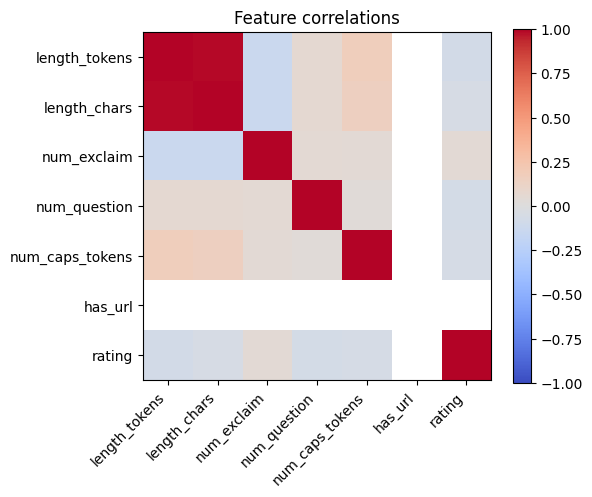

,length_tokens,length_chars,num_exclaim,num_question,num_caps_tokens,has_url,rating
length_tokens,1.00,0.99,-0.13,0.06,0.17,NaN,-0.08
length_chars,0.99,1.00,-0.13,0.06,0.16,NaN,-0.05
num_exclaim,-0.13,-0.13,1.00,0.05,0.04,NaN,0.05
num_question,0.06,0.06,0.05,1.00,0.03,NaN,-0.07
num_caps_tokens,0.17,0.16,0.04,0.03,1.00,NaN,-0.06
has_url,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,-0.08,-0.05,0.05,-0.07,-0.06,NaN,1.00


In [19]:
num_cols = ["length_tokens","length_chars","num_exclaim","num_question","num_caps_tokens","has_url","rating"]
corr = df[num_cols].astype(float).corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature correlations")
plt.tight_layout()
plt.show()
corr.round(2)

9) Quick TF-IDF keywords per class (optional utility)
    - Show words strongly associated with "has_url" reviews (proxy for ads).

In [21]:
def class_tfidf_top_terms(texts, labels, top_k=20):
    vec = TfidfVectorizer(stop_words="english", min_df=2)
    X = vec.fit_transform(texts)
    vocab = np.array(vec.get_feature_names_out())
    # mean tfidf per term within each class
    mask1 = labels.astype(bool).values
    X1 = X[mask1]
    X0 = X[~mask1]
    m1 = np.asarray(X1.mean(axis=0)).ravel()
    m0 = np.asarray(X0.mean(axis=0)).ravel()
    lift = (m1 + 1e-9) / (m0 + 1e-9)
    idx = np.argsort(lift)[::-1][:top_k]
    return pd.DataFrame({"term": vocab[idx], "lift_has_url": lift[idx].round(3)})

if df["has_url"].sum() > 0:
    print("Terms over-indexed in has_url==True:")
    display(class_tfidf_top_terms(df["text_clean"], df["has_url"], 25))

10) Save quick summary report (CSV)

In [22]:
summary = {
    "n_reviews": len(df),
    "n_businesses": df["business_name"].nunique(),
    "has_url_pct": round(df["has_url"].mean()*100, 2),
    "short_pct": round(df["is_short"].mean()*100, 2),
    "avg_tokens": round(df["length_tokens"].mean(), 2),
    "avg_exclaim": round(df["num_exclaim"].mean(), 3),
    "avg_caps_tokens": round(df["num_caps_tokens"].mean(), 3),
}
report_df = pd.DataFrame([summary])
os.makedirs("../reports", exist_ok=True)
report_df.to_csv("../reports/eda_summary.csv", index=False)
report_df


,n_reviews,n_businesses,has_url_pct,short_pct,avg_tokens,avg_exclaim,avg_caps_tokens
0,1100,100,0.0,22.73,20.05,0.085,0.045
